# About this notebook

This Jupyter notebook is designed to perform a comprehensive analysis of text classification on the AG News dataset using both traditional machine learning and Transformers. Here are some key points covered in the notebook:

- __Baseline Model with Naive Bayes__: The notebook begins by creating a baseline model using Naive Bayes, a traditional machine learning algorithm frequently used for text classification tasks. This model serves as a benchmark for evaluating the performance of subsequent models.

- __NewsClassifier for Transformer Models__: The notebook then utilizes the NewsClassifier class to evaluate the performance of various Transformer models on the AG News  dataset "out-of-the-box" without any fine-tuning. This allows for an understanding of how well these pre-trained models perform on the task right away.

- __Fine-Tuning BERT__: After this, we delve into fine-tuning one specific Transformer model: BERT. Fine-tuning involves further training this pre-trained model on the AG News dataset. This process allows the model to specialize its already learned knowledge towards the news text classification task.

- __Evaluation__: Lastly, we evaluate and compare the results from the fine-tuned BERT model against the baseline Naive Bayes model and the initial out-of-the-box Transformer models' performance. This comparison is performed using a confusion matrix created from a classification report from the `sklearn` library, with a particular focus on the weighted F1-score and accuracy as key performance metrics. This detailed comparison provides insight into how much improvement the fine-tuning process brought about, and the relative strengths and weaknesses of each model for this particular task.




# Imports

In [ ]:
# Load setup.py file
%load ../utils/setup.py
%run ../utils/setup.py

In [ ]:
# Load utils.py file
%load ../utils/utils.py
%run ../utils/utils.py

In [ ]:
# Load plotting.py file
%load ../utils/plotting.py
%run ../utils/plotting.py

In [ ]:
useGPU()

Have fun with this chapter!🥳


# Allocate enough RAM

Let us try to get a __GPU__ with at least __15GB RAM__ for our notebook.

In [ ]:
# crash colab to get more RAM -> uncomment to use
#!kill -9 -1

We can execute the following command `!free -h`  to see if we have enough RAM and `!nvidia-smi` to get more info about our GPU type we got assigned.
If the allocated GPU is too small, the above cell can be used to run the command to crash the notebook hoping to get a better GPU after the crash, since the GPU is randomly allocated.


In [ ]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:           12Gi       1.1Gi       7.1Gi       2.0Mi       4.5Gi        11Gi
Swap:            0B          0B          0B


In [ ]:
!nvidia-smi

Tue May  2 14:37:06 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch

if torch.cuda.is_available():
    gpu_device = torch.device('cuda')
    gpu_info = torch.cuda.get_device_properties(gpu_device)
    gpu_memory = gpu_info.total_memory / 1e9  # Convert bytes to gigabytes
    print(f"GPU: {gpu_info.name}, Total Memory: {gpu_memory:.2f} GB")
else:
    print("No GPU detected.")


GPU: Tesla T4, Total Memory: 15.84 GB


# Imports

In [ ]:
# Basic imports
import numpy as np  
import pandas as pd
from datasets import load_dataset

# Torch imports
from torch.utils.data import Dataset  

# Transformers imports
from transformers import (EarlyStoppingCallback, AutoTokenizer, AutoModelForSequenceClassification, BertTokenizer, 
                          BertForSequenceClassification, ElectraTokenizer, ElectraForSequenceClassification, 
                          RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments) 

# Evaluation imports
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
import evaluate  # Evaluation script from Hugging Face

# Visualization imports
import matplotlib.pyplot as plt  

# Miscellaneous imports 
import random  
import warnings  

# Suppress warnings related to undefined metrics in classification reports
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# Suppress logging messages from the transformers library
import transformers
transformers.logging.set_verbosity(transformers.logging.ERROR)


In [ ]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


## Set seed function

The `set_seed` function sets the seed for various random number generators used in the notebook to ensure that the results are reproducible. It first sets the seed for `numpy` and `torch`. If a GPU is available, it then sets the seed for all `cuda` operations and ensures that the results are deterministic.

Setting the seed is important when working with random processes in order to ensure that the results are consistent between runs. This is especially important when training machine learning models, as different random seeds can result in different model performance.

In [ ]:
set_seed()

In [ ]:
accuracy_metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return accuracy_metric.compute(predictions=predictions, references=labels)

# News classification

In [ ]:
# Load the AG News dataset
ag_news_dataset = load_dataset('ag_news')
test_set = ag_news_dataset["test"]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Dataset ag_news downloaded and prepared to /root/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

## Reduce and split dataset

In [ ]:
train_fraction = 0.1
val_fraction = 0.01
test_fraction = 1000 / len(ag_news_dataset['test'])

ag_news_train, ag_news_val, _ = reduce_dataset_size_and_split(ag_news_dataset['train'], train_fraction=train_fraction, val_fraction=val_fraction)
_, _, ag_news_test = reduce_dataset_size_and_split(ag_news_dataset['test'], train_fraction=1-test_fraction, val_fraction=0, test_fraction=test_fraction)

print(f"Train dataset size: { len(ag_news_train)}")
print(f"Validation dataset size: {len(ag_news_val)}")
print(f"Test dataset size:  {len(ag_news_test)}")


Train dataset size: 12000
Validation dataset size: 1200
Test dataset size:  1000


## Plot data distribution

In [ ]:
ag_news_train_df = pd.DataFrame(ag_news_train)
ag_news_val_df = pd.DataFrame(ag_news_val)
ag_news_test_df = pd.DataFrame(ag_news_test)


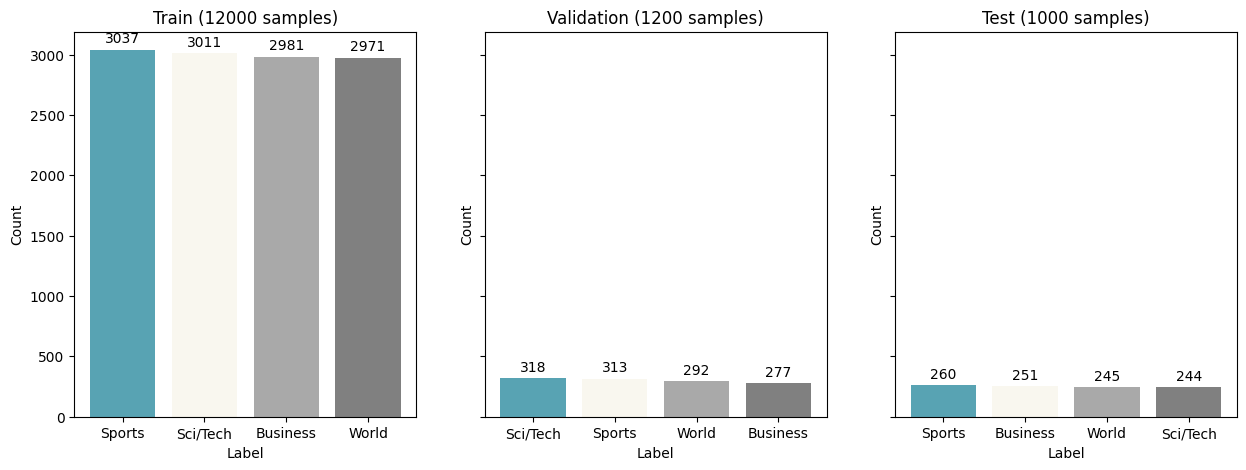

In [ ]:
label_map = {
    0: 'World',
    1: 'Sports',
    2: 'Business',
    3: 'Sci/Tech'
}

datasets = [ag_news_train_df, ag_news_val_df, ag_news_test_df]
dataset_names = ["Train", "Validation", "Test"]

plot_dataset_distribution(datasets, dataset_names, label_map=label_map)


# Using Naïve Bayes classifier as baseline

Naive Bayes methods are a set of supervised learning algorithms often used for text classification, spam detection, and other similar tasks. These algorithms are based on applying Bayes' theorem with the "naive" assumption of conditional independence between every pair of features given the value of the class variable.

Bayes' theorem states the following relationship, given class variable \(y\) and dependent feature vector \(x_1\) through \(x_n\):

$$
P(y | x_1, \ldots, x_n) = \frac{P(y) P(x_1, \ldots, x_n | y)}{P(x_1, \ldots, x_n)}
$$

Using the naive conditional independence assumption:

$$
P(x_i | y, x_1, \ldots, x_{i-1}, x_{i+1}, \ldots, x_n) = P(x_i | y),
$$

for all \(i\), this relationship is simplified to:

$$
P(y | x_1, \ldots, x_n) = \frac{P(y) \prod_{i=1}^n P(x_i | y)}{P(x_1, \ldots, x_n)}
$$

Now let's consider the case where the feature vector consists of words $(w_1, w_2, w_3, \dots, w_n)$. The formula for the Naive Bayes method becomes:

\begin{align*}
\underset{y \in\{\text {Pos,Neg}\}}{\arg \max } P\left(y \mid w_1, w_2, w_3, \dots, w_n\right) &=\underset{y \in\{\text {Pos,Neg}\}}{\arg \max } \frac{P\left(w_1, w_2, w_3, \dots, w_n \mid y\right) \cdot P(y)}{P\left(w_1, w_2, w_3, \dots, w_n\right)} \\
&=\underset{y \in\{\text {Pos,Neg}\}}{\arg \max } P\left(w_1, w_2, w_3, \dots, w_n \mid y\right) \cdot P(y) \\
&=\underset{y \in\{\text {Pos,Neg}\}}{\arg \max } P\left(w_1 \mid y\right) \cdot \prod_{i=2}^n P\left(w_i \mid w_1, \dots, w_{i-1}, y\right) \cdot P(y) \\
&=\underset{y \in\{\text {Pos,Neg}\}}{\arg \max } \prod_{i=1}^n P\left(w_i \mid y\right) \cdot P(y)
\end{align*}

In the second line, we remove the denominator $(P\left(w_1, w_2, w_3, \dots, w_n\right))$ as it's constant given the input. In the third line, we apply the chain rule of probability. Finally, in the fourth line, we use the naive conditional independence assumption to simplify the product of conditional probabilities.



In [ ]:
# Create the TfidfVectorizer and MultinomialNB pipeline
nb_pipeline = make_pipeline(TfidfVectorizer(), MultinomialNB())

# Train the model
nb_pipeline.fit(ag_news_train_df["text"], ag_news_train_df["label"])

# Make predictions on the test dataset
test_predictions = nb_pipeline.predict(ag_news_test_df["text"])


             Accuracy  F1 Score  World F1  Sports F1  Business F1
Sci/Tech F1
Model
Naive Bayes     0.887  0.886835  0.895277   0.965649     0.836653
0.845996
Classification Report:
              precision    recall  f1-score   support

       World       0.90      0.89      0.90       245
      Sports       0.96      0.97      0.97       260
    Business       0.84      0.84      0.84       251
    Sci/Tech       0.85      0.84      0.85       244

    accuracy                           0.89      1000
   macro avg       0.89      0.89      0.89      1000
weighted avg       0.89      0.89      0.89      1000



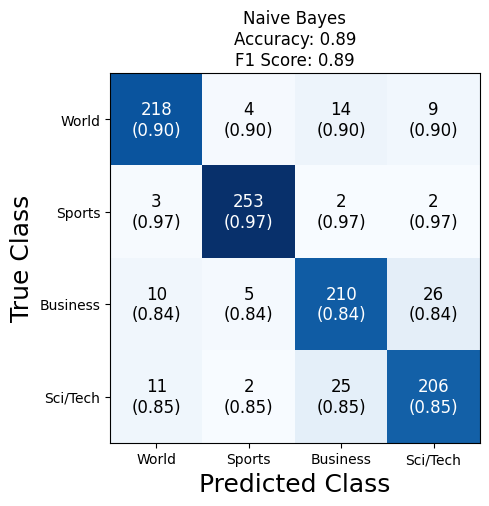

In [ ]:
true_labels = ag_news_test_df["label"]
pred_labels = test_predictions
target_names = ["World", "Sports", "Business", "Sci/Tech"]
model_name = "Naive Bayes"

evaluation_df_bayes = create_evaluation_df_and_plot(true_labels, pred_labels, target_names, model_name)


# Evaluate different transformer models


The `TextClassifier` class, which gets imported from the book's repository is for evaluating multiple models on a text classification task. Its primary purpose is to streamline the process of model evaluation, providing quantitative and visual feedback on the performance of each model.

### Attributes

- `test_set`: This is the test dataset used for evaluating the models. It's expected to include 'sentence' and 'label' columns.

- `models`: A dictionary of models to be evaluated. The keys are the model names and the values are the model checkpoint paths.

- `target_names`: A list of class names that correspond to the labels in the 'label' column of the test dataset.

- `num_examples` (optional): The number of examples to use from the test set for evaluation. The default is 100.

- `seed_value` (optional): The seed value for random operations in numpy and torch. This ensures reproducibility. The default is 0.

### Methods

- `set_seed(seed_value=42)`: A static method that sets the seed for numpy, torch, and cudnn to ensure the reproducibility of results.

- `evaluate_models(num_columns=3, figsize=(15, 10))`: This method evaluates all the models on the test set and provides a summary of the results. This includes the accuracy, F1 score, and a confusion matrix for each model. The results are also plotted for visual comparison between models.

### Usage

This class is useful for comparing and selecting the best model for a given news classification task. It visualizes the performance of each model in a clear and concise manner, providing insights not only into the overall accuracy of the models but also into their performance on individual classes. This can help identify models that perform exceptionally well or poorly on specific classes, facilitating the selection of the most appropriate model for the task at hand.

✅ Evaluating BERT...


✅ Evaluating RoBERTa...


✅ Evaluating DistilBERT...


✅ Evaluating DeBERTa...


✅ Evaluating ALBERT...


✅ Evaluating ELECTRA...


            Accuracy  F1 Score  World F1  Sports F1  Business F1
Sci/Tech F1
Model
BERT            0.16  0.114231  0.000000   0.076923     0.215686
0.195122
RoBERTa         0.37  0.199854  0.000000   0.000000     0.000000
0.540146
DistilBERT      0.33  0.203815  0.464000   0.307692     0.000000
0.000000
DeBERTa         0.30  0.138462  0.461538   0.000000     0.000000
0.000000
ALBERT          0.20  0.070588  0.000000   0.336134     0.000000
0.000000
ELECTRA         0.28  0.174292  0.446429   0.000000     0.000000
0.109091


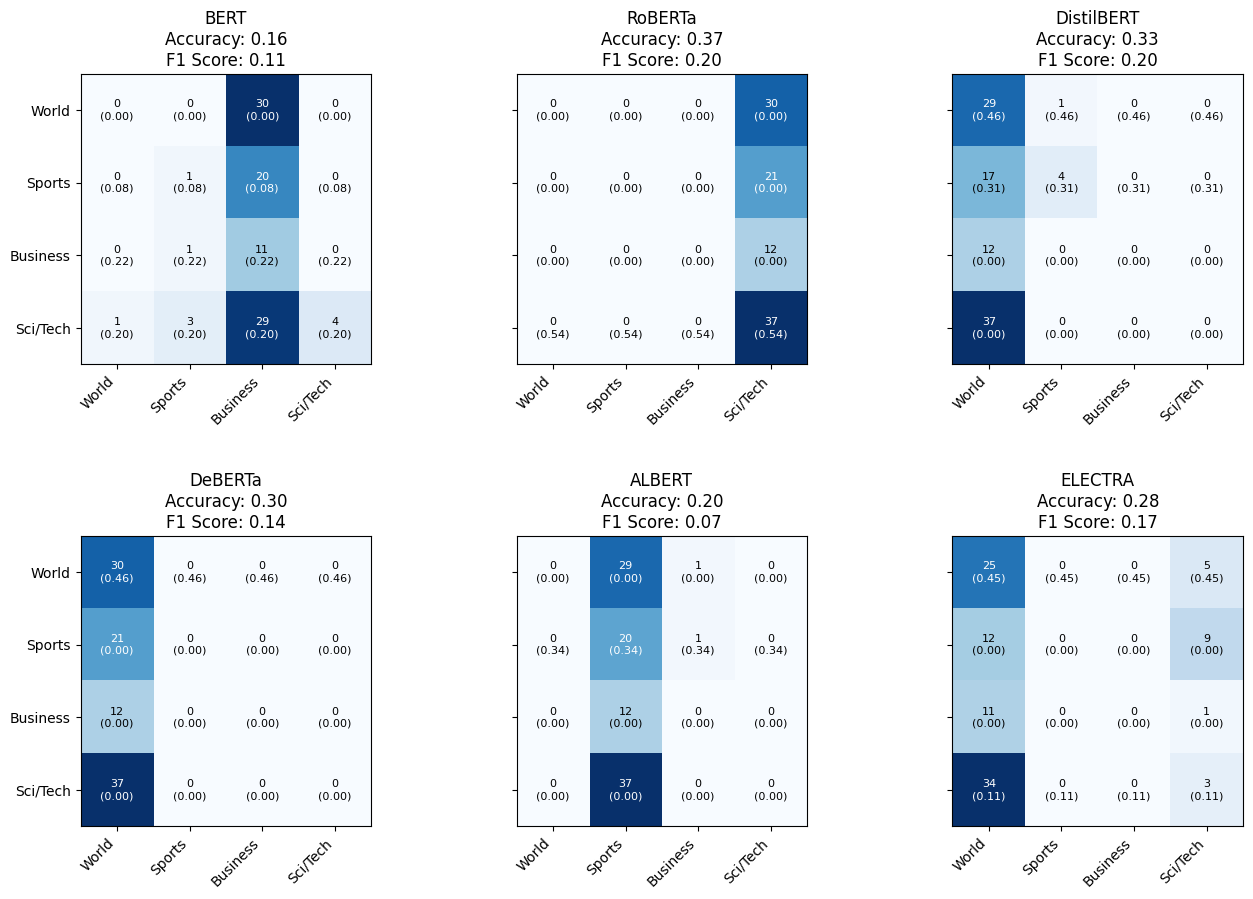

In [ ]:
models = {
    "BERT": "bert-base-uncased",
    "RoBERTa": "roberta-base",
    "DistilBERT": "distilbert-base-uncased",
    "DeBERTa": "microsoft/deberta-base",
    "ALBERT": "albert-base-v2",
    "ELECTRA": "google/electra-base-discriminator",
}

ag_news_target_names = ["World", "Sports", "Business", "Sci/Tech"]
ag_news_classifier = TextClassifier(test_set, models, ag_news_target_names)
evaluation_df_ag_news_before = ag_news_classifier.evaluate_models(num_columns=3, figsize=(15, 10))

# Fine tune transformer model on downstream task

In this section of the Jupyter notebook, we are setting up a pipeline for training a text classification model using the BERT model from Hugging Face's transformers library. The task is to perform topic modelling on news texts.

First, we load the BERT tokenizer and model. We are using the `bert-base-uncased` version of the model, which is a smaller and faster variant that still delivers good results. The model is a sequence classification model, which is suitable for our task of text classification. We set the number of labels to 4, indicating that we are dealing with a four-class classification problem.

Next, we define the maximum sequence length and batch size. The sequence length is the maximum number of tokens that the model can handle, and the batch size is the number of examples to process at once during training. These are hyperparameters that can be tuned to optimize performance.

We then create Dataset objects for the training, validation, and test sets using the TextClassificationDataset class we defined earlier. These Dataset objects will be used to feed data into the model during training and evaluation.

The EarlyStoppingCallback is set up to monitor the validation loss during training and stop the training process if it doesn't see significant improvement for 10 consecutive epochs. This helps to prevent overfitting.

The TrainingArguments class is used to set various parameters for the training process, such as the number of epochs, the learning rate, and the batch size. We also specify that we want to save the model that achieves the best performance on the validation set.

Finally, we initialize a Trainer object with our model, the training arguments, the training and validation datasets, and the compute_metrics function for evaluating performance during training. We also add the early stopping callback to the Trainer. The Trainer is then used to train the model. After training, the model that achieved the best performance on the validation set is loaded, ready for evaluation on the test set.

## Prepare dataset for fine-tuning

In [ ]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Define the BERT model with `ignore_mismatched_sizes=True`
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)

# Define the maximum sequence length and batch size
max_length = 128
batch_size = 32

# Create the training, validation, and test datasets
train_dataset = TextClassificationDataset(ag_news_train, tokenizer, max_length)
val_dataset = TextClassificationDataset(ag_news_val, tokenizer, max_length)
test_dataset = TextClassificationDataset(ag_news_test, tokenizer, max_length)

## Early stopping

In [ ]:
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=10,  # Stop training if the metric doesn't improve for 10 epochs
    early_stopping_threshold=2e-5,  # Minimum change in the monitored metric to be considered as an improvement
)

## Fine-tune model 

In [ ]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    overwrite_output_dir=True,
    num_train_epochs=5,
    per_device_train_batch_size=batch_size,
    save_strategy="epoch",  
    save_total_limit=2,
    evaluation_strategy="epoch",
    learning_rate=4e-5,
    weight_decay=0.01,
    logging_strategy="epoch",
    logging_steps=10,
    load_best_model_at_end=True,  # Load the best model at the end of training
)


# Initialize the trainer with the compute_metrics function
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,  
    callbacks=[early_stopping_callback]
)

# Train the model
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 12000
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1875
  Number of trainable parameters = 109485316
***** Running Evaluation *****
  Num examples = 1200
  Batch size = 8


{'loss': 0.3401, 'learning_rate': 3.2000000000000005e-05, 'epoch': 1.0}


Saving model checkpoint to ./results/checkpoint-375
Configuration saved in ./results/checkpoint-375/config.json


{'eval_loss': 0.2344578057527542, 'eval_accuracy': 0.92, 'eval_runtime': 26.9532, 'eval_samples_per_second': 44.522, 'eval_steps_per_second': 5.565, 'epoch': 1.0}


Model weights saved in ./results/checkpoint-375/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1200
  Batch size = 8


{'loss': 0.163, 'learning_rate': 2.4e-05, 'epoch': 2.0}


Saving model checkpoint to ./results/checkpoint-750
Configuration saved in ./results/checkpoint-750/config.json


{'eval_loss': 0.2350313365459442, 'eval_accuracy': 0.9275, 'eval_runtime': 25.3148, 'eval_samples_per_second': 47.403, 'eval_steps_per_second': 5.925, 'epoch': 2.0}


Model weights saved in ./results/checkpoint-750/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1200
  Batch size = 8


{'loss': 0.0851, 'learning_rate': 1.6000000000000003e-05, 'epoch': 3.0}


Saving model checkpoint to ./results/checkpoint-1125
Configuration saved in ./results/checkpoint-1125/config.json


{'eval_loss': 0.2579900920391083, 'eval_accuracy': 0.9283333333333333, 'eval_runtime': 25.3735, 'eval_samples_per_second': 47.293, 'eval_steps_per_second': 5.912, 'epoch': 3.0}


Model weights saved in ./results/checkpoint-1125/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-750] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1200
  Batch size = 8


{'loss': 0.0364, 'learning_rate': 8.000000000000001e-06, 'epoch': 4.0}


Saving model checkpoint to ./results/checkpoint-1500
Configuration saved in ./results/checkpoint-1500/config.json


{'eval_loss': 0.3256364166736603, 'eval_accuracy': 0.9266666666666666, 'eval_runtime': 23.9794, 'eval_samples_per_second': 50.043, 'eval_steps_per_second': 6.255, 'epoch': 4.0}


Model weights saved in ./results/checkpoint-1500/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1125] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1200
  Batch size = 8


{'loss': 0.0156, 'learning_rate': 0.0, 'epoch': 5.0}


Saving model checkpoint to ./results/checkpoint-1875
Configuration saved in ./results/checkpoint-1875/config.json


{'eval_loss': 0.35126903653144836, 'eval_accuracy': 0.9266666666666666, 'eval_runtime': 24.7839, 'eval_samples_per_second': 48.419, 'eval_steps_per_second': 6.052, 'epoch': 5.0}


Model weights saved in ./results/checkpoint-1875/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1500] due to args.save_total_limit


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results/checkpoint-375 (score: 0.2344578057527542).


{'train_runtime': 9651.8736, 'train_samples_per_second': 6.216, 'train_steps_per_second': 0.194, 'train_loss': 0.12803777821858725, 'epoch': 5.0}


TrainOutput(global_step=1875, training_loss=0.12803777821858725, metrics={'train_runtime': 9651.8736, 'train_samples_per_second': 6.216, 'train_steps_per_second': 0.194, 'train_loss': 0.12803777821858725, 'epoch': 5.0})

## Save fine-tuned model

In [ ]:
# Save the fine-tuned model
model.save_pretrained("fine_tuned_bert_ag_news")

Configuration saved in fine_tuned_bert_ag_news/config.json
Model weights saved in fine_tuned_bert_ag_news/pytorch_model.bin


## Evaluate fine-tuned model

loading configuration file fine_tuned_bert_ag_news/config.json
Model config BertConfig {
  "_name_or_path": "fine_tuned_bert_ag_news",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.26.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_siz

                 Accuracy  F1 Score  World F1  Sports F1  Business F1
\
Model
Fine-tuned BERT     0.918  0.917863  0.933884   0.973384     0.879346

                 Sci/Tech F1
Model
Fine-tuned BERT     0.882236
Classification Report:
              precision    recall  f1-score   support

       World     0.9456    0.9224    0.9339       245
      Sports     0.9624    0.9846    0.9734       260
    Business     0.9034    0.8566    0.8793       251
    Sci/Tech     0.8599    0.9057    0.8822       244

    accuracy                         0.9180      1000
   macro avg     0.9178    0.9173    0.9172      1000
weighted avg     0.9185    0.9180    0.9179      1000



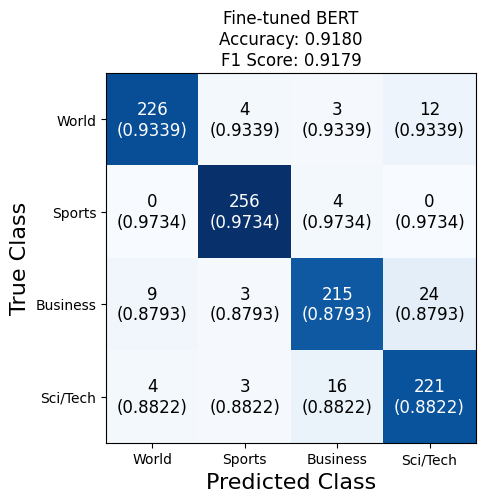

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("fine_tuned_bert_ag_news", num_labels=4)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
evaluation_df_ag_news_bert = evaluate_model(model, tokenizer, ag_news_test, ["World", "Sports", "Business", "Sci/Tech"], model_name="Fine-tuned BERT", is_dataframe=False)


In [ ]:
evaluation_df_ag_news_all = evaluation_df_ag_news_before._append(evaluation_df_ag_news_bert) 
evaluation_df_ag_news_all = evaluation_df_ag_news_all._append(evaluation_df_bayes)
evaluation_df_ag_news_all

<ipython-input-26-92e3f0634c29>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  evaluation_df_ag_news_all = evaluation_df_ag_news_before.append(evaluation_df_ag_news_bert)
<ipython-input-26-92e3f0634c29>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  evaluation_df_ag_news_all = evaluation_df_ag_news_all.append(evaluation_df_bayes)


,Accuracy,F1 Score,World F1,Sports F1,Business F1,Sci/Tech F1
Model,,,,,,
BERT,0.160,0.114231,0.000000,0.076923,0.215686,0.195122
RoBERTa,0.370,0.199854,0.000000,0.000000,0.000000,0.540146
DistilBERT,0.330,0.203815,0.464000,0.307692,0.000000,0.000000
DeBERTa,0.300,0.138462,0.461538,0.000000,0.000000,0.000000
ALBERT,0.200,0.070588,0.000000,0.336134,0.000000,0.000000
ELECTRA,0.280,0.174292,0.446429,0.000000,0.000000,0.109091
Fine-tuned BERT,0.918,0.917863,0.933884,0.973384,0.879346,0.882236
Naive Bayes,0.887,0.886835,0.895277,0.965649,0.836653,0.845996
